## Simulating  Active Brownian motion
In this notebook, we simulate the trajectory of a single, non-interacting active Brownian particle. Unlike passive Brownian particles (e.g. pollen grains in water) that do diffusive random walks, active Brownian particles (ABPs) propel themselves with directed motion in addition to diffusing randomly. 

The APB model can be used to accurately desribe the motion of certain types of cells, those which locomote actively using focal adhesions. The distribution of focal adhesions within a cell may vary continuously, tending to reorient the cell with respect to it's past momentum and giving rise to different speeds with which the cell moves. It is this angular reorientation which can be modelled as a diffusive process.

Durotaxis is the preference for cells to move preferentially towards a stiffer substrate. In this project we implement durotaxis by incorporating the dependence of a cell's rotational diffusion properties on the stiffness of the medium upon which a cell is crawling.

*It should be noted that although all of the simulations in this project display the trajectories or data associated with numerous cells, intercellular interactions are not taken into account here. This is a simple single cell model.*

In [ ]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('L', default = 3, help = 'width of stiffness transition region', type = float)

parser.add_argument('ks', default = 1, help = 'stiffness on soft side of system', type = float)

parser.add_argument('kh', default = 50, help = 'stiffness on hard side of system', type = float)

parser.add_argument('dt', default = 0.01, help = 'discrete timestep', type = float)

parser.add_argument('nw', default = 100, help = '# of cells', type = int)

parser.add_argument('ns', default = 10**6, help = '# of steps each cell takes', type = int)

args = parser.parse_args()

L = args.L

ks = args.ks

kh = args.kh 

dt = args.dt

num_walks = args.nw

num_steps = args.ns

In [201]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import random as rand
from scipy import stats

import os.path
from os import path

### 2D Confined ABP model with durotaxis: an overview.
Cells perform a ballistic step (proportional to $dt$) and random walk in the space of $\theta$-values. 

Furthermore we implement walled boundary conditions, treating a wall as a reflecting surface. If a walker goes beyond the confining boundary of the box, it's position is altered so as to keep it in the box. Note that when this reflection of a walker by a boundary occurs, the velocity of the walker is not infuenced by the reflection.

We also incorporate 1D substrate stiffness into the model. Specifically the stiffness will depend on the location of a walker within the confining box. To the left (-x) the substrate is more soft, to the right (+x) it is more stiff, and in the center is a transition region. The rotational diffusion constant of each walker is then made to depend on the stiffness of the substrate upon which it is walking, so that a walker in the stiffer region will be taking steps more ballistically, while a walker in the softer region will be taking steps more diffusively. 

To extract meaningful data, we collect statistics from an ensemble of identically prepared systems, i.e. individual cells which are placed in identical environments, whose ballistic and diffusive components of motion are drawn from the same distributions.

# Mean Square Displacement (MSD)

The following cell defines a function that calculates the mean square displacement of a number of cells as they experience durotaxis within a confined environment. It takes in the number of cells (num_walks), the number of discrete steps (num_steps) each cell takes, the time interval between each discrete step (dt), and the width of the transition region (L) as input parameters.

Parameters within the fucntion which can be further altered are: the size of the bounding system (Bbox), the soft and hard region stiffness parameters (ks and kh), and ABP parameters such as inherent cell velocity (vel), baseline rotational diffusion constant (Drot0), and translational diffusion constant (Dtrans). 

In [199]:
def get_msd_durotaxis(num_walks, num_steps, dt, L):

    #ABP model parameters: ballistic velocity, time step, rotational diffusion constant, translational diffusion constant
    vel =1.0; 
    Drot0 = 5; Dtrans = 0.001;

    #bounding size of box
    Bbox = 20

    
    # initialize arrays that store x,y and theta values, as well as initial particle position and angle
    x_vals = np.zeros(num_walks); y_vals = np.zeros(num_walks); theta_vals = 2*np.pi*(rand(num_walks) - 0.5)
    displacement = np.zeros(num_walks); msd_at_step = np.zeros(num_steps); k_vals = np.ones(num_walks)
    Drot_vals=np.zeros(num_walks);

    #loop through steps for all cells
    for i in range(num_steps):
        
        #loop through cells
        for j in range(num_walks):
            
            #implement walled boundaries
            if x_vals[j] > Bbox/2:
                x_vals[j] -= 2*(x_vals[j] - Bbox/2)
            elif x_vals[j] < -Bbox/2:
                x_vals[j] -= 2*(x_vals[j] + Bbox/2)
            elif x_vals[j] < Bbox/2 and x_vals[j] > -Bbox/2:
                x_vals[j] += 0
            
            if y_vals[j] > Bbox/2:
                y_vals[j] -= 2*(y_vals[j] - Bbox/2)
            elif y_vals[j] < -Bbox/2:
                y_vals[j] -= 2*(y_vals[j] + Bbox/2)
            elif y_vals[j] < Bbox/2 and y_vals[j] > -Bbox/2:
                y_vals[j] += 0
            
            #determine substrate stiffness based on position
            if x_vals[j] > -L and x_vals[j] < L:
                k_vals[j] = ks + ((kh-ks)/(2*L))*(x_vals[j] + L)
            elif x_vals[j] > L:
                k_vals[j] = kh
            elif x_vals[j] < -L:
                k_vals[j] = ks
            
        #calculate rotational diffusion constant (for all cells) based on substrate stiffness 
        Drot_vals = Drot0/k_vals
        
            
        # calculate diffusive/random steps. For the x- and y-,we generate 
        #a random number between -1 & 1 to ensure that the walker can step in both directions(up/down and left/right).
        # update coordinates (including ballistic step along angle and diffusive step)
        x_vals += vel*dt*np.cos(theta_vals) + np.sqrt(2*Dtrans*dt)*2*(rand(num_walks)-0.5);
        y_vals += vel*dt*np.sin(theta_vals) + np.sqrt(2*Dtrans*dt)*2*(rand(num_walks)-0.5) 
        
        # update angles by rotational diffusion step (again looping through each cell)
        for k in range(num_walks):
            theta_vals[k] += 2*np.pi*np.sqrt(2*Drot_vals[k]*dt) * rand(1)
                
        displacement = (x_vals**2 + y_vals**2)
        # store msd after every interval steps
        msd_at_step[i] = np.mean(displacement)
        
    time_at_step = np.linspace(0, num_steps*dt, num_steps)        
        
    return time_at_step, msd_at_step

The following cell executes the previously defined get_msd_durotaxis function, and plots the collected MSD data as a function of time on a loglog plot.

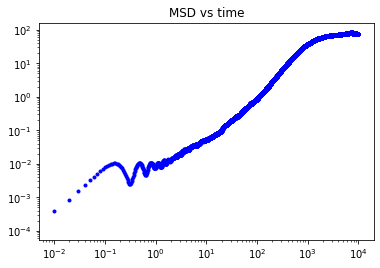

In [205]:
time_at_step, msd_at_step = get_msd_durotaxis(num_walks, num_steps, dt, L)

plt.loglog(time_at_step,msd_at_step, 'b.');
plt.title('MSD vs time')

filename = 'durotaxis_MSD.png'
plt.savefig(filename)